# Homework 3

In this problem, we are going to simulate Bennett et al.'s quantum teleportation protocol. We encourage everyone to take a look at the <a href="https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895">original paper</a>, entitled <em>Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels</em> [Phys. Rev. Lett. <b>70</b>, 1895 (1993)]. It has been cited <b>16000+</b> since it was published in 1993! In this problem, you are going to simulate the protocol using Qiskit.

# The Protocol 

## Step 1: Generate shared entanglement 

Alice wants to send a generic quantum state $|\psi \rangle = \alpha |0\rangle + \beta |1 \rangle$ to Bob. Unfortunately, the <b>No Cloning Theorem</b> tells us that quantum mechanics does not allow us to copy a generic quantum state. So, Alice can't simply copy $\Psi$ and send it along a quantum channel to Bob. She can achieve her goal of transmitting her state to Bob with the help of a classical channel and entanglement. To generate this entanglement, we imagine a third party, Charlie, that will be able to create a Bell pair and give half to Alice and half to Bob. Let's say Charlie creates and shares the state

$$|\Psi^+\rangle =\frac{1}{\sqrt{2}}(|0\rangle_A |0\rangle_B +|1\rangle_A |1\rangle_B )$$

Now, Alice has her state $|\psi\rangle$ and half the Bell pair, and Bob has the other half. The full state is given as

$$|\psi\rangle \otimes |\Psi^+\rangle = \frac{1}{\sqrt{2}}(\alpha |0\rangle|0\rangle |0\rangle +\alpha |0\rangle|1\rangle |1\rangle + \beta |1\rangle|0\rangle |0\rangle +\beta |1\rangle|1\rangle |1\rangle ).$$

Convince yourself that this is the correct form of the total state!

## Step 2: Alice operates locally 

Now, the protocol dictates that Alice applies a CNOT on her two qubits, followed by a Hadamard on just the first qubit. The resulting state, as you should check, is 

$$(H \otimes I \otimes I)(CNOT \otimes I) |\psi \rangle |\Psi^+\rangle = \frac{1}{2}(\alpha(|000\rangle + |011\rangle + |100 \rangle + |111\rangle) + \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)).$$

Now, if you squint at this a while, you will see that it can be factorized into a more illuminating form:

$$(H \otimes I \otimes I)(CNOT \otimes I) |\psi \rangle |\Psi^+\rangle = \frac{1}{2} ( |00> \otimes (\alpha |0\rangle + \beta |1\rangle ) + |01\rangle \otimes (\alpha |1\rangle + \beta |0\rangle ) + |10 \rangle \otimes (\alpha |0\rangle - \beta |1\rangle ) + |11 \rangle \otimes (\alpha |1\rangle - \beta |0\rangle )),$$

where we have written the tensor product between Alice and Bob's systems explicitly.

## Step 3: Alice measures

Alice now carries out a measurement in the computational basis on her two qubits. This is a partial measurement on the three-party state. Following the rules of partial measurements, we can show the following states occur with equal probability 

$$ \text{Alice obtains: } 00 \rightarrow \text{Bob's state becomes: } \alpha |0 \rangle + \beta |1\rangle,$$ 
$$ \text{Alice obtains: } 01 \rightarrow \text{Bob's state becomes: } \alpha |1 \rangle + \beta |0\rangle,$$
$$ \text{Alice obtains: } 10 \rightarrow \text{Bob's state becomes: } \alpha |0 \rangle - \beta |1\rangle,$$
$$ \text{Alice obtains: } 11 \rightarrow \text{Bob's state becomes: } \alpha |1 \rangle - \beta |0\rangle.$$

## Step 4: Classical communication

At this stage, Alice gives Bob a call and tells him what outcome she got. Bob uses this information to decide what operation he needs to apply to his half of the original Bell state in order to obtain Alice's original state (thus completing the teleportation protocol). You can probably guess the rules from looking at Bob's states in step 3, but we write them here nonetheless

$$ \text{Alice obtains: } 00  \rightarrow \text{Bob applies: } I \text{ to obtain: } |\psi\rangle, $$ 
$$ \text{Alice obtains: } 01  \rightarrow \text{Bob applies: } X \text{ to obtain: } |\psi\rangle, $$ 
$$ \text{Alice obtains: } 10  \rightarrow \text{Bob applies: } Z \text{ to obtain: } |\psi\rangle, $$ 
$$ \text{Alice obtains: } 11  \rightarrow \text{Bob applies: } ZX \text{ to obtain: } |\psi\rangle. $$ 

Thus, by conditioning on Alice's outcome, Bob is able to prepare a copy of Alice's original state $|\psi \rangle$ in his lab! This works no matter how far apart their labs are (the record at the time of writing is teleportation over 143km!).

# Setting up the circuit

Now that we have reviewed the teleportation protocol, it is time for you to implement it! 

In [2]:
# Import the relevant packages
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

In [4]:
## STEP 1
# This function takes in a QuantumCircuit (qc) and two integers (a,b)
def create_bell_pair(qc,a,b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

## STEP 2
# This function takes in a QuantumCircuit (qc) and two integers (psi,a)
def alice_gates(qc, psi, a):
    qc.barrier()
    qc.cx(psi, a)
    qc.h(psi)

## STEP 3
# This function takes in a QuantumCircuit (qc) and two integers (a,b)
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

# STEP 4
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz,crx) to decide which gates to apply based on Alice's measurement outcomes
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical bit instead of a qubit
    qc.barrier()
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

## Your turn! Now that we have defined the relevant functions, you just need to call them in the correct order to set-up the teleportation circuit.

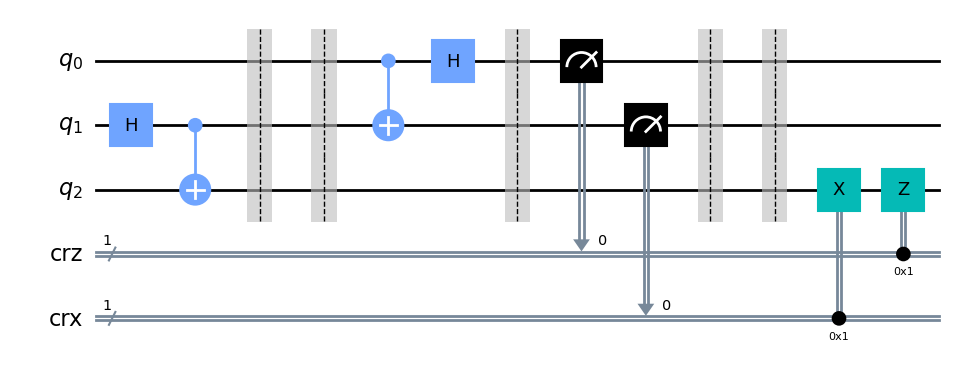

In [7]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 1
# Create shared entanglement
create_bell_pair(qc, 1,2)

## STEP 2
# Alice operates locally on her qubits
qc.barrier()
alice_gates(qc, 0,1)
## STEP 3
# Alice measures and calls Bob to tell him the outcome
measure_and_send(qc,0,1)

## STEP 4
# Bob decodes locally based on Alice's message to him
qc.barrier()
bob_gates(qc,2,crz,crx)
# Draw the output
qc.draw(output="mpl")

# Simulating the protocol

Now that we have the circuit set-up, we can simulate the protocol. We will have Alice generate a random quantum state she wishes to teleport to Bob. Then, using your code from above, you will simulate the protocol and see that, no matter what state Alice starts with, and no matter what measurement outcome she obtains, Bob can always recover her state once they've communicated classically!

<IPython.core.display.Latex object>

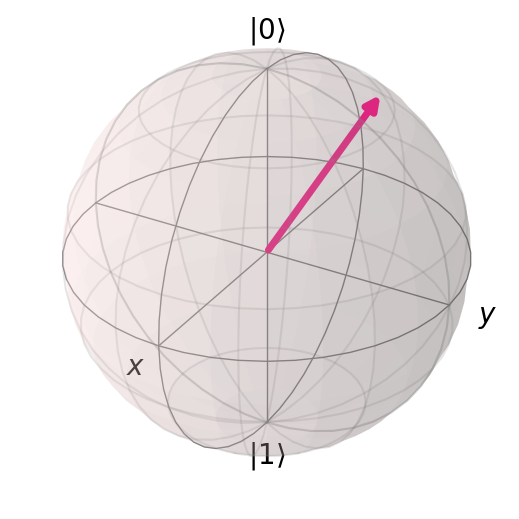

In [8]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display the statevector nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))

# This function obtains the spherical coordinates from a given quantum state
def get_spherical_coordinates(statevector):
    # Convert to polar form:
    r0 = np.abs(statevector[0])
    ϕ0 = np.angle(statevector[0])

    r1 = np.abs(statevector[1])
    ϕ1 = np.angle(statevector[1])

    # Calculate the coordinates:
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    ϕ = ϕ1 - ϕ0
    return [r, θ, ϕ]

plot_bloch_vector(get_spherical_coordinates(psi), coord_type = 'spherical')

In [9]:
# This code will allow Alice to initialize her state |psi> in q0
init_gate = Initialize(psi)
init_gate.label = "init"

Now we will initialize Alice's state $|\psi\rangle$ into a random state and then use our code from above to generate the teleportation circuit. <b>Note: just use the same Step 1-4 code you generated above.</b>

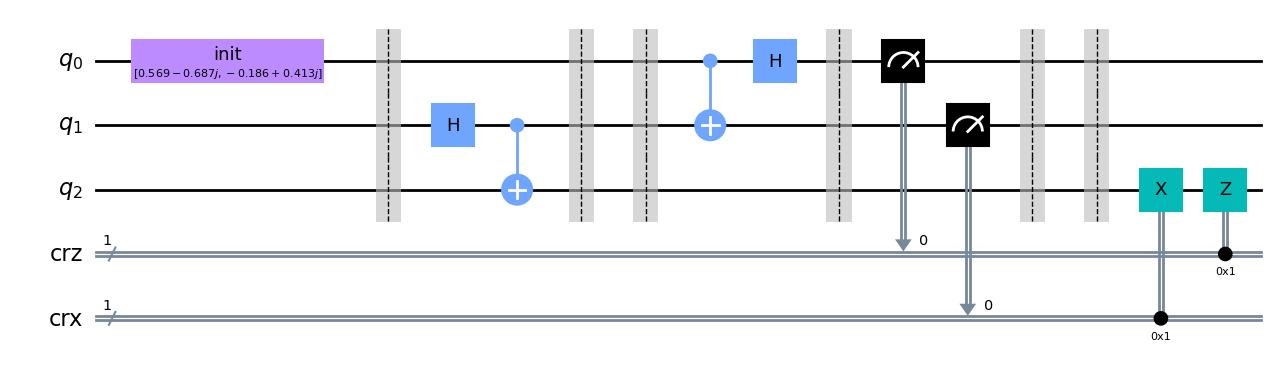

In [13]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0 as |psi>
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
create_bell_pair(qc, 1,2)

## STEP 2
# Alice operates locally on her qubits
qc.barrier()
alice_gates(qc, 0,1)
## STEP 3
# Alice measures and calls Bob to tell him the outcome
measure_and_send(qc,0,1)

## STEP 4
# Bob decodes locally based on Alice's message to him
qc.barrier()
bob_gates(qc,2,crz,crx)

# Display the circuit
qc.draw(output="mpl")

Now, lets run the simulation and see how our three qubits end up!

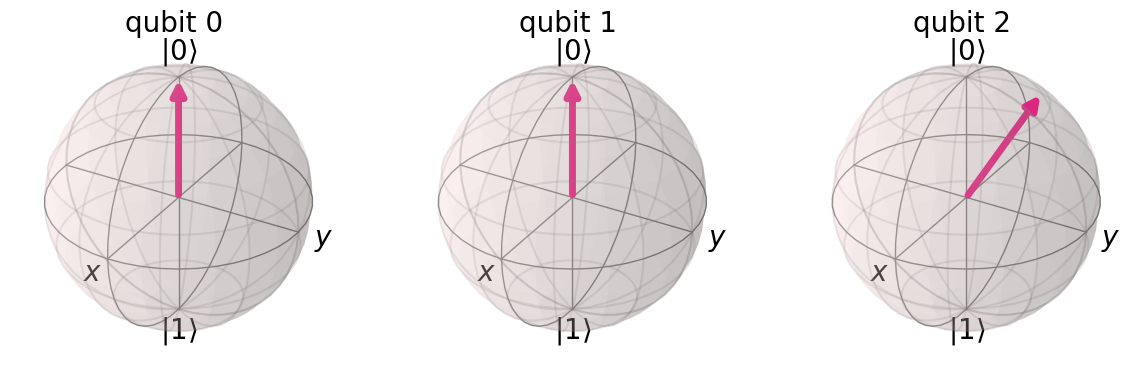

In [11]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

Run the above two cell many times. Note that regardless of the final state of Alice's qubits, Bob recovers the random $|\psi \rangle$ Alice wanted to transmit! You can go back up to the random state generation and run the whole thing from the start as well. 

## Congrats! You just teleported your first qubit! Save this notebook as a pdf and turn it in as normal.